In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import pickle, os


In [2]:
# Synthetic dataset generation
np.random.seed(42)
n = 500
student_ids = [f"S{1000+i}" for i in range(n)]
names = [f"Student_{i}" for i in range(n)]
classes = np.random.choice(["Grade 6", "Grade 7", "Grade 8", "Grade 9", "Grade 10"], size=n, p=[0.15,0.2,0.25,0.2,0.2])

comprehension = np.clip(np.random.normal(70, 12, n), 30, 100)
attention = np.clip(comprehension + np.random.normal(0, 10, n), 20, 100)
focus = np.clip(np.random.normal(65, 15, n), 15, 100)
retention = np.clip(0.6*comprehension + np.random.normal(0, 12, n), 10, 100)
engagement_time = np.clip(np.random.exponential(scale=40, size=n), 5, 240)

assessment_score = (0.35*comprehension + 0.25*attention + 0.2*focus + 0.15*retention)
assessment_score = assessment_score + np.random.normal(0, 6, n)
assessment_score = np.clip(assessment_score, 0, 100)

df = pd.DataFrame({
    "student_id": student_ids,
    "name": names,
    "class": classes,
    "comprehension": np.round(comprehension,1),
    "attention": np.round(attention,1),
    "focus": np.round(focus,1),
    "retention": np.round(retention,1),
    "engagement_time": np.round(engagement_time,1),
    "assessment_score": np.round(assessment_score,1)
})

df.head()


,student_id,name,class,comprehension,attention,focus,retention,engagement_time,assessment_score
0,S1000,Student_0,Grade 8,74.1,79.9,84.5,34.7,7.9,71.6
1,S1001,Student_1,Grade 10,92.5,88.9,88.4,60.6,141.2,78.0
2,S1002,Student_2,Grade 9,81.4,87.3,65.5,43.2,5.0,67.4
3,S1003,Student_3,Grade 8,63.1,74.2,53.7,37.7,20.7,51.4
4,S1004,Student_4,Grade 7,59.2,67.4,71.9,42.1,53.6,58.1


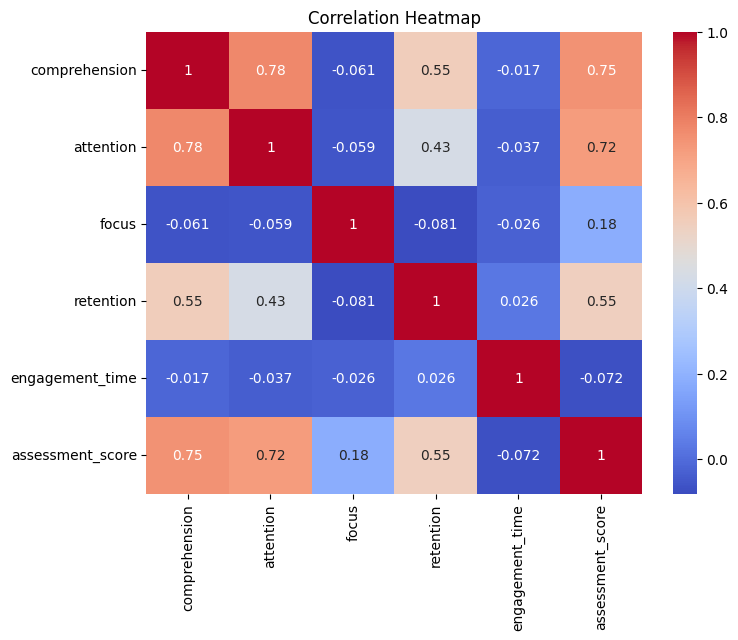

In [3]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[["comprehension","attention","focus","retention","engagement_time","assessment_score"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


Linear Regression -> RMSE: 6.467170567402758  R2: 0.6659390966647611
Random Forest     -> RMSE: 7.047278324112087  R2: 0.6033203986751998


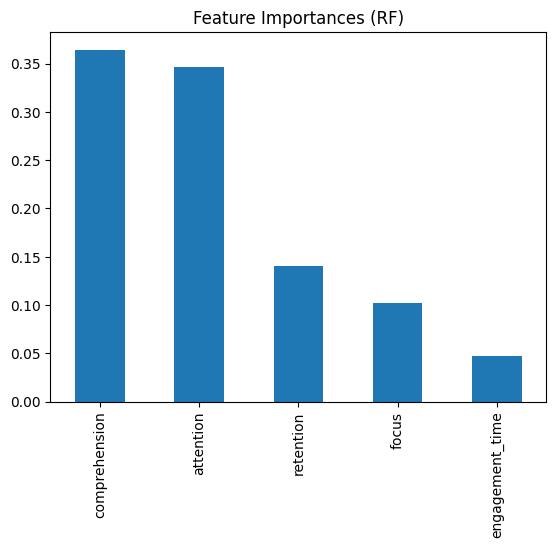

In [4]:
# ML Modeling
features = ["comprehension","attention","focus","retention","engagement_time"]
X = df[features].copy()
y = df["assessment_score"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
r2_lr = r2_score(y_test, pred_lr)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf = r2_score(y_test, pred_rf)

print("Linear Regression -> RMSE:", rmse_lr, " R2:", r2_lr)
print("Random Forest     -> RMSE:", rmse_rf, " R2:", r2_rf)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
importances.plot(kind="bar", title="Feature Importances (RF)")
plt.show()


         comprehension  attention  focus  retention  engagement_time  \
cluster                                                                
0                71.14      71.65  53.17      45.13            27.73   
1                59.36      58.16  72.12      31.45            30.32   
2                71.42      70.66  65.19      43.98           117.43   
3                82.16      85.47  71.11      52.36            28.22   

         assessment_score  
cluster                    
0                   60.43  
1                   53.81  
2                   61.21  
3                   72.44  


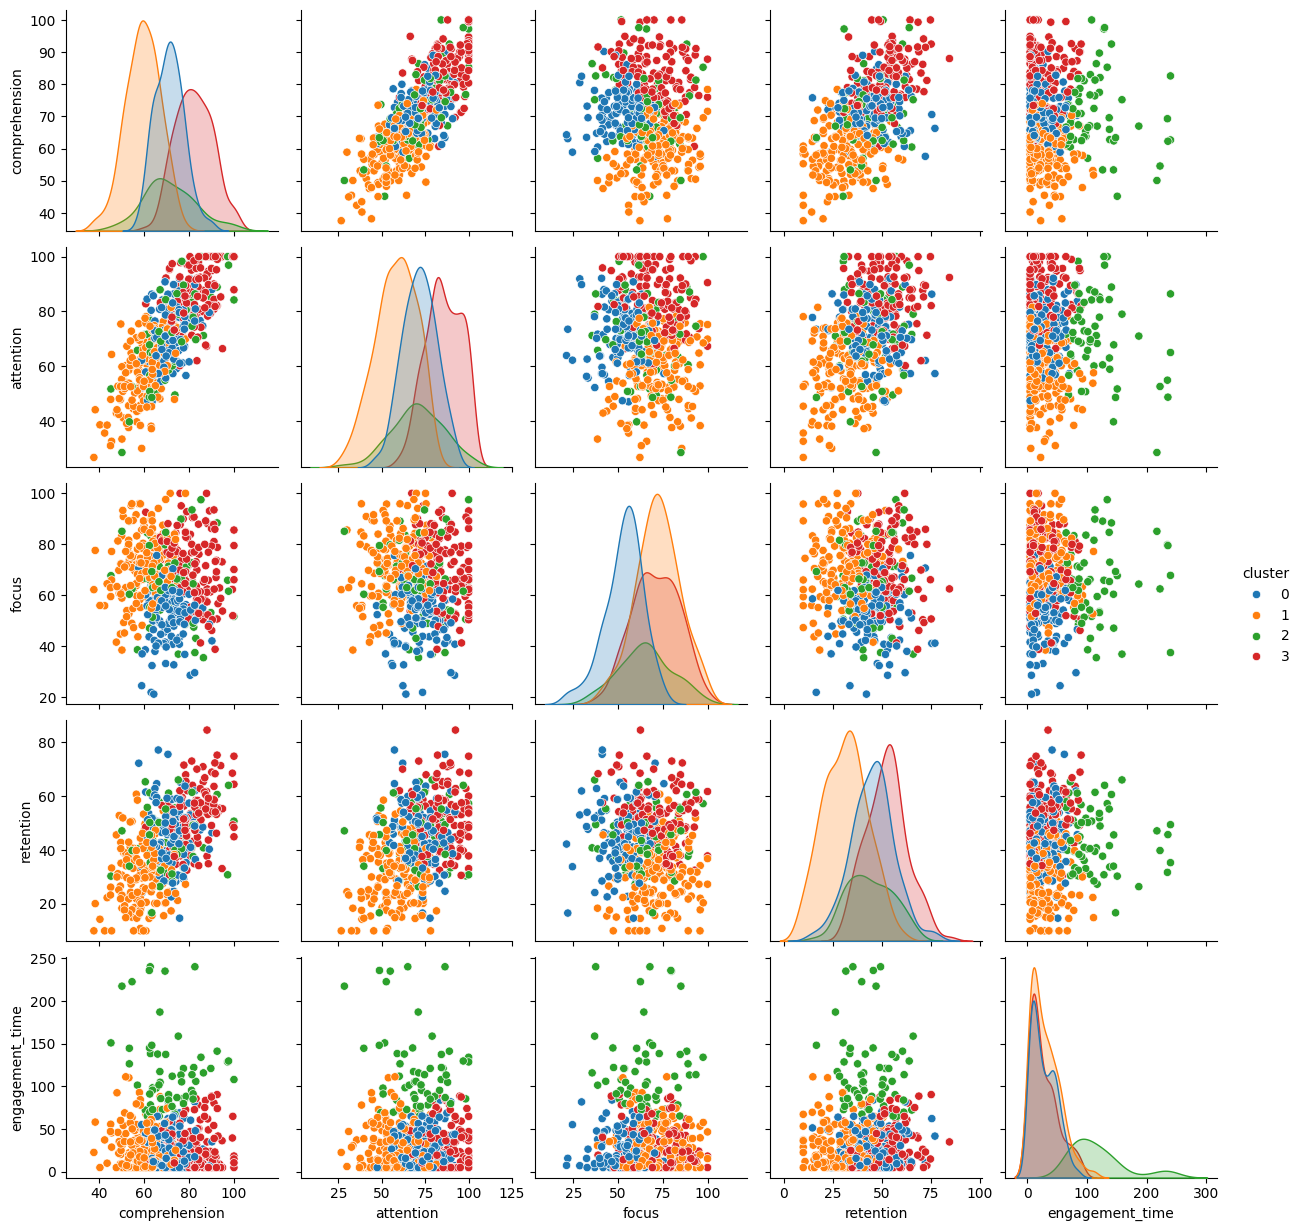

In [5]:
# Clustering students
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df["cluster"] = clusters

cluster_profile = df.groupby("cluster")[features + ["assessment_score"]].mean().round(2)
print(cluster_profile)

sns.pairplot(df[features + ["cluster"]], hue="cluster", palette="tab10")
plt.show()


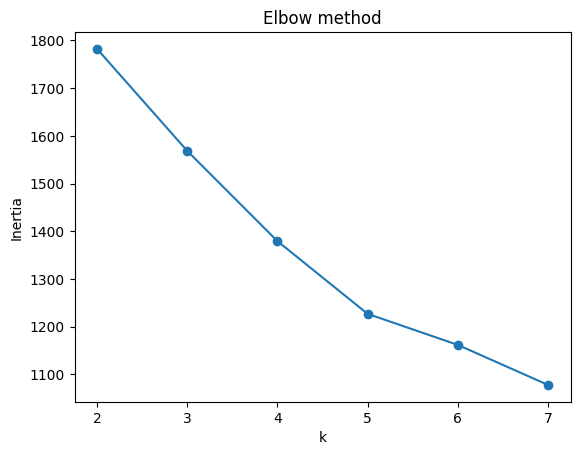

,comprehension,attention,focus,retention,engagement_time,assessment_score
cluster,,,,,,
0,71.14,71.65,53.17,45.13,27.73,60.43
1,59.36,58.16,72.12,31.45,30.32,53.81
2,71.42,70.66,65.19,43.98,117.43,61.21
3,82.16,85.47,71.11,52.36,28.22,72.44


In [7]:
features = X.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# pick k using elbow
inertia = []
K = range(2,8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
plt.plot(K, inertia, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.show()

# choose k=4 (example)
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# profile clusters
cluster_profile = df.groupby('cluster')[["comprehension","attention","focus","retention","engagement_time","assessment_score"]].mean().round(2)
cluster_profile


In [6]:
# Save outputs
os.makedirs("outputs", exist_ok=True)
df.to_csv("outputs/students_with_clusters.csv", index=False)
with open("outputs/rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)
print("Files saved in outputs/")


Files saved in outputs/
